### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [139]:
env = 'pc'  # 'pc', 'colab'
using_gpu = False

In [140]:
%%capture
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/'

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [141]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt




In [142]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [143]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

Data shape: X: (800, 2), Y: (800,)


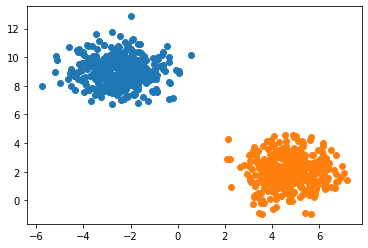

In [144]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)

def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

weights = calc_weight_matrix(X, weight_func = euclidian_similarity)


Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 400 instances of object 0.0
We have to delabel 388 instances
Found 400 instances of object 1.0
We have to delabel 388 instances

    We have 776 unlabeled data
    Out of 800
    


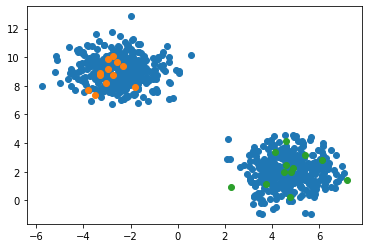

In [145]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [146]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled

# Gradient descent

In [147]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [148]:
X.shape

(800, 2)

In [149]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 10, 
    delta_loss_limit = 0.008, 
    stop_loss = 2198,
    weight_matrix = weights
)

Iteration: 0, Loss: 2386.9616490893322, delta loss: 2386.9616490893322
Iteration: 1, Loss: 2297.3105158759913, delta loss: 89.65113321334093
Iteration: 2, Loss: 2249.058788697388, delta loss: 48.25172717860323
Iteration: 3, Loss: 2217.529779201682, delta loss: 31.529009495706305
Iteration: 4, Loss: 2196.4153300722205, delta loss: 21.114449129461264




Accuracy: 1.0


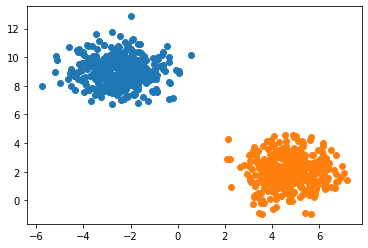

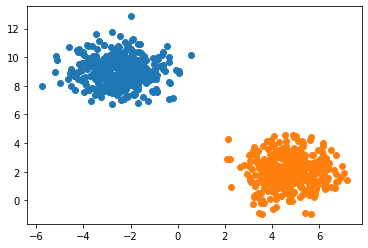

In [150]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

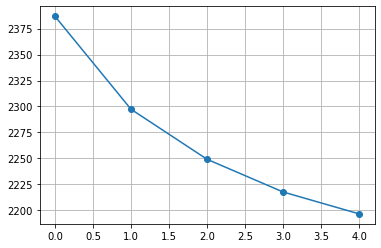

In [151]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [152]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [153]:
X.shape

(800, 2)

In [154]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 15, 
    delta_loss_limit = 0.008, 
    stop_loss= 2174,
    weight_matrix = weights
)

Iteration: 0, Loss: 2386.9616490893322, Delta: 2386.9616490893322
Iteration: 1, Loss: 2273.291275786913, Delta: 113.6703733024192
Iteration: 2, Loss: 2220.0796524901434, Delta: 53.21162329676963
Iteration: 3, Loss: 2191.127361093176, Delta: 28.95229139696721
Iteration: 4, Loss: 2174.439955362402, Delta: 16.687405730774117
Iteration: 5, Loss: 2164.8629815872437, Delta: 9.576973775158422


Accuracy: 1.0


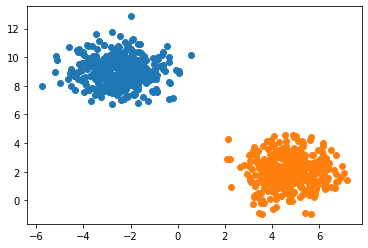

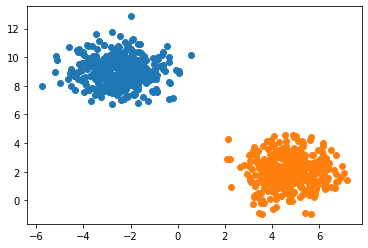

In [155]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

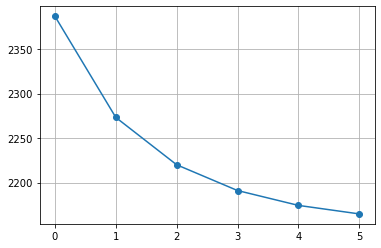

In [156]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

## BCGD random sampling

In [157]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00015,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [158]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled, 
    iter_limit = 10,
    delta_loss_limit = 0.0,
    stop_loss= 2380,
    weight_matrix = weights
)

Iteration: 0, Loss: 2386.9616490893322, Delta: 2386.9616490893322
Iteration: 1, Loss: 2386.9490875587057, Delta: 0.012561530626499007
Iteration: 2, Loss: 2386.9034193766547, Delta: 0.04566818205103118
Iteration: 3, Loss: 2386.873448495004, Delta: 0.029970881650569936
Iteration: 4, Loss: 2386.8397060654183, Delta: 0.03374242958579998
Iteration: 5, Loss: 2386.8266113701484, Delta: 0.013094695269955992
Iteration: 6, Loss: 2386.823064854408, Delta: 0.003546515740254108
Iteration: 7, Loss: 2386.785633738955, Delta: 0.03743111545327338
Iteration: 8, Loss: 2386.744737110032, Delta: 0.04089662892283741
Iteration: 9, Loss: 2386.697275509016, Delta: 0.04746160101603891


Accuracy: 0.52125


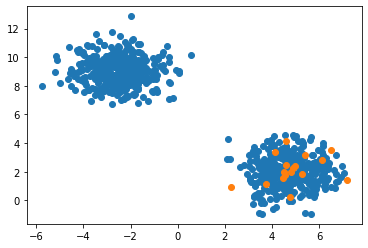

In [159]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

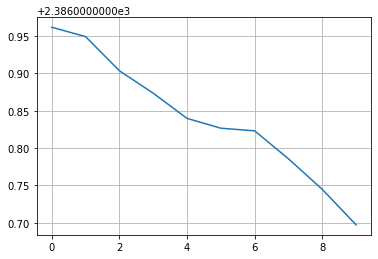

In [160]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [161]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [167]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 50, 
    delta_loss_limit = 0.0001,
    stop_loss = 2300,
    weight_matrix = weights
)

Iteration: 0, Loss: 2386.9616490893322, Delta: 2386.9616490893322
Iteration: 1, Loss: 2273.9907631681463, Delta: 112.97088592118598


Accuracy: 1.0


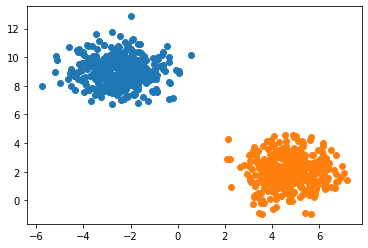

In [168]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

In [169]:
accuracy_score(Y, Y_preds_BCGD_cyclic)

1.0

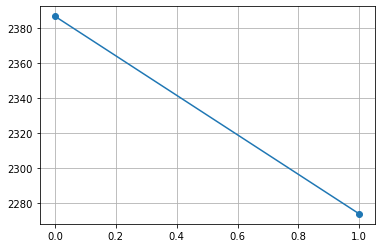

In [170]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [171]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [65]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [67]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss_percent):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [58]:
iters_limit = 100
delta_loss_limit = 0.0001
stop_loss= 19.7

if using_gpu:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()

    with tf.device(device_name):
        print(f'with GPU')
        preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss_percent
        )

else:
    print(f'without GPU')
    preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss_pecent = stop_loss_percent
        )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

without GPU


NameError: name 'compare_models' is not defined

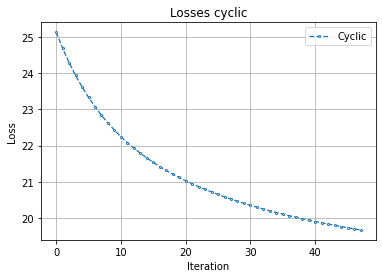

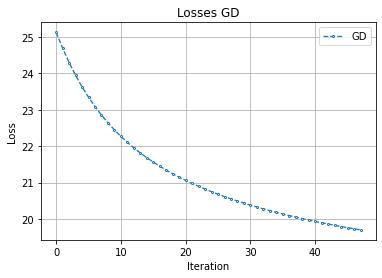

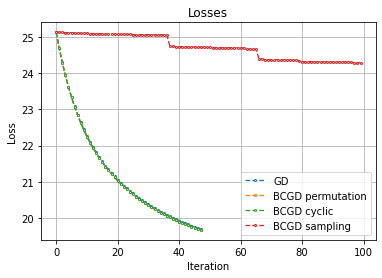

In [ ]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots(figsize = (6, 4))

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(losses, 'Losses', y_label = 'Loss')

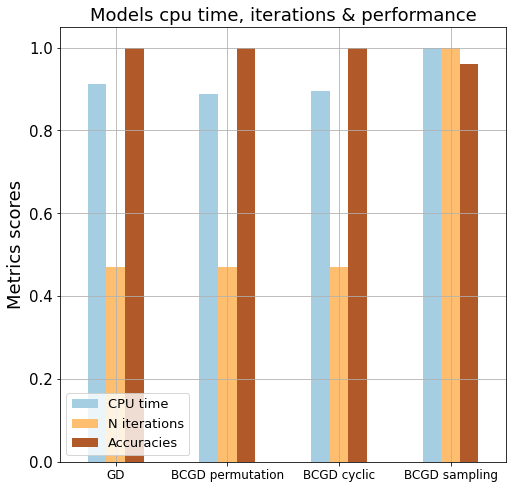

In [ ]:
def plot_bar_metrics(metrics_df):
    
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired',
        figsize = (8, 8)
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

In [ ]:
print(accuracies)
print(n_iters)
print(cpu_times)

{'GD': 1.0, 'BCGD permutation': 1.0, 'BCGD cyclic': 1.0, 'BCGD sampling': 0.96}
{'GD': 47, 'BCGD permutation': 47, 'BCGD cyclic': 47, 'BCGD sampling': 100}
{'GD': 1.6719717999999375, 'BCGD permutation': 1.6277214000000413, 'BCGD cyclic': 1.6390458000000763, 'BCGD sampling': 1.8320298000001003}


# Real dataset

In [ ]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

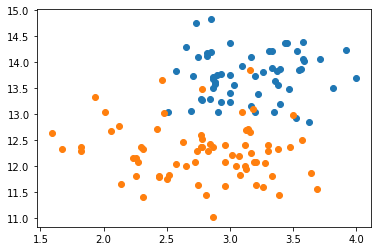

In [ ]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [ ]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = 0.06, # DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 55 instances
Found 71 instances of object 1.0
We have to delabel 66 instances


In [ ]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

NameError: name 'plot_clusters' is not defined

In [ ]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iter_limit=50,
    delta_loss_limit = 0.003
)

NameError: name 'GradientDescentSolver' is not defined

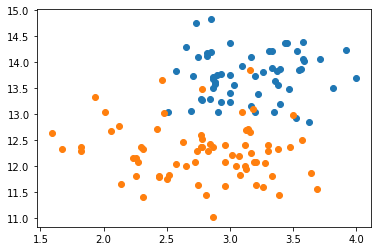

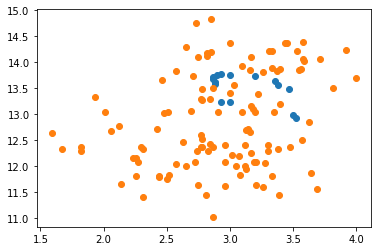

In [ ]:
plot_clusters(
    X_real,
    Y_real
)
plot_clusters(
    X_real,
    Y_real_preds
)